# In this notebook we will create service area boundaries for each park managed by the city of austin



In [1]:
import geopandas as gpd
import os
import getpass
import matplotlib.pyplot as plt
import re
import pandas as pd
wd = os.getcwd()
wd = wd[:wd.find('notebooks')]

In [2]:
coaparks = gpd.read_file(wd+"data/coaparks/BOUNDARIES_city_of_austin_parks.shp")

#Link to data and metadata: https://data.austintexas.gov/Locations-and-Maps/BOUNDARIES_city_of_austin_parks/8f2b-a4q5

coaparks

# Separate these before hand! 
coaparks.head(10)

,ASSET_MGMT,LOCATION_N,ADDRESS,CITY_MUNIC,COUNTY,STATE,STREET_NUM,STREET_NAM,STREET_TYP,ZIPCODE,...,MXPRIORITY,MXLOADID,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,geometry
0,412,Stratford Overlook Greenbelt,"3006 Stratford Dr., Austin, Texas 78746",Austin,Travis,TX,3006,Stratford,Dr.,78746,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.403262e+03,420.672106,"POLYGON ((3099906.430145308 10076413.89003989,..."
1,413,Highland Neighborhood Park,"403 W St Johns Ave., Austin, Texas 78752",Austin,Travis,TX,403,W St Johns,Ave.,78752,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.048800e+04,422.279483,"POLYGON ((3123253.446115226 10095987.26952823,..."
2,354,Palma Plaza Pocket Park,"1524 Palma Plz., Austin, Texas 78703",Austin,Travis,TX,1524,Palma,Plz,78703,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.007678e+04,492.661534,"POLYGON ((3109560.790101632 10075621.8601279, ..."
3,398,Oertli Neighborhood Park,"12613 Blaine Rd., Austin, Texas 78753",Austin,Travis,TX,12613,Blaine,Rd.,78753,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.671883e+05,2404.916487,"POLYGON ((3142167.801987216 10117512.55423348,..."
4,370,Decker Tallgrass Prairie Preserve,"8001 Decker Ln., Austin, Texas 78724",Austin,Travis,TX,8001,Decker,Ln.,78724,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.515843e+07,26672.772067,"POLYGON ((3155053.00948447 10084108.4848869, 3..."
5,364,Peace Point at Town Lake Metro Park,"2200 S Lakeshore Blvd., Austin, Texas 78741",Austin,Travis,TX,2200,S Lakeshore,Blvd,78741,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.381281e+05,4343.236948,(POLYGON ((3121502.000143051 10063076.00004905...
6,298,Norwood Tract at Town Lake Metro Park,"1009 Edgecliff Ter., Austin, Texas 78704",Austin,Travis,TX,1009,Edgecliff,Ter,78704,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.150892e+05,7283.191248,(POLYGON ((3115397.693454057 10064828.94175315...
7,204,Mayfield Park,"3805 W 35th St., Austin, Texas 78703",Austin,Travis,TX,3805,W 35th,St.,78703,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.022823e+06,4794.005509,"POLYGON ((3105648.160459712 10086501.19007523,..."
8,187,Kennemer Pool,"1031 Payton Gin Rd., Austin, Texas 78758",Austin,Travis,TX,1031,Payton Gin,Rd.,78758,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.556303e+04,960.033300,"POLYGON ((3125342.31037581 10104470.85984448, ..."
9,217,Norman School Park,"3901 Tannehill Ln., Austin, Texas 78721",Austin,Travis,TX,3901,Tannehill,Ln.,78721,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.087978e+05,2981.252775,"POLYGON ((3135631.310138971 10074747.45013131,..."


In [3]:
len(coaparks)

298

## Creation of buffers of for 1/4 mile (400 meters) and 1/2 a mile (800 meters) and Varied based  on size or type of Park
   #### Exclude cemetries from the park counts
   #### For the variable buffers follow the guidelines below 

In [13]:
coaparks_quarter = coaparks.copy()
coaparks_half = coaparks.copy()

coaparks_quarter['geometry'] = coaparks_quarter['geometry'].buffer(400)
coaparks_half['geometry'] = coaparks_half['geometry'].buffer(800)
#neighborhood = .5 between 2 and 30 acres
#pocket = .25 <2acres
#district = 1 31 < acres < 200
#greenbelt = 5 look in Names 
#metro = 5  >200 acres 
#schools Look in Names

# series.loc[indexer]
# df.loc[row.indexer, column.indexer]
coaparks_vari = coaparks.copy()
num_neigh = 0
num_pocket = 0
num_district=0
num_greenbelt = 0
num_metro=0
num_schools = 0
num_cem=0
num_perserve = 0

for row in coaparks_vari['ASSET_SIZE'].index:
    if coaparks_vari['ASSET_SIZE'][row] < 2:
        # The record is a pocket park, we buffer by .25 mile
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(400)
        num_pocket += 1
        
    elif coaparks_vari['ASSET_SIZE'][row] >= 2 and coaparks_vari['ASSET_SIZE'][row] <= 30:
        # The record is a neighborhood park, thus buffer by .5 miles
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(800)
        num_neigh += 1
    
    elif coaparks_vari['ASSET_SIZE'][row] >= 31 and coaparks_vari['ASSET_SIZE'][row] < 200:
        # This record is a district park
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(1600)
        num_district += 1
        
    elif coaparks_vari['ASSET_SIZE'][row] >= 200:
        # This record is a metro
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(4000)
        num_metro += 1
   
    if 'Greenbelt' in coaparks['LOCATION_N'][row]:
        # We want to make sure we check that all of the greenblets are buffered 
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row].buffer(4000)
        num_greenbelt +=1
    
    if 'Preserve' in coaparks['LOCATION_N'][row]:
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row].buffer(1600)
        num_perserve +=1
    
    if 'School' in coaparks['LOCATION_N'][row]:
        # School parks are given a .25 mile buffer
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row].buffer(400)
        num_schools += 1
    
    if 'Cemetery' in coaparks['LOCATION_N'][row]:
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row]
        coaparks_vari.drop('Cemetery', inplace=True)
        num_cem +=1
        
    if 'Cemetery' in coaparks['LOCATION_N'][row]:
        coaparks_quarter['geometry'].loc[row] = coaparks['geometry'].loc[row]
        coaparks_quarter.drop('Cemetery', inplace=True)
        #num_cem +=1
        
    if 'Cemetery' in coaparks['LOCATION_N'][row]:
        coaparks_half['geometry'].loc[row] = coaparks['geometry'].loc[row]
        coaparks_half.drop('Cemetery', inplace=True)
        #num_cem +=1
        
print('pocket', num_pocket)
print('neigh', num_neigh)
print('district', num_district)
print('metro', num_metro)
print('greenbelt', num_greenbelt)
print('school', num_schools)
print('cemetery', num_cem)

pocket 57
neigh 167
district 50
metro 23
greenbelt 50
school 22
cemetery 0


In [14]:
coaparks_quarter

,ASSET_MGMT,LOCATION_N,ADDRESS,CITY_MUNIC,COUNTY,STATE,STREET_NUM,STREET_NAM,STREET_TYP,ZIPCODE,...,MXPRIORITY,MXLOADID,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,geometry
0,412,Stratford Overlook Greenbelt,"3006 Stratford Dr., Austin, Texas 78746",Austin,Travis,TX,3006,Stratford,Dr.,78746,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.403262e+03,420.672106,"POLYGON ((3099659.296639044 10076099.36654302,..."
1,413,Highland Neighborhood Park,"403 W St Johns Ave., Austin, Texas 78752",Austin,Travis,TX,403,W St Johns,Ave.,78752,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.048800e+04,422.279483,"POLYGON ((3122902.889064272 10096179.9084496, ..."
2,354,Palma Plaza Pocket Park,"1524 Palma Plz., Austin, Texas 78703",Austin,Travis,TX,1524,Palma,Plz,78703,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.007678e+04,492.661534,"POLYGON ((3109810.268547321 10075962.94345399,..."
3,398,Oertli Neighborhood Park,"12613 Blaine Rd., Austin, Texas 78753",Austin,Travis,TX,12613,Blaine,Rd.,78753,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.671883e+05,2404.916487,"POLYGON ((3142020.189037629 10117140.78761702,..."
4,370,Decker Tallgrass Prairie Preserve,"8001 Decker Ln., Austin, Texas 78724",Austin,Travis,TX,8001,Decker,Ln.,78724,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.515843e+07,26672.772067,"POLYGON ((3154723.006204365 10083882.87548335,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,423,Red Bluff Neighborhood Park,"5805 Harold Ct., Austin, Texas 78721",Austin,Travis,TX,5805,Harold,Ct.,78721,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.134473e+05,3463.806548,"POLYGON ((3134463.513475158 10071434.2702909, ..."
294,420,MLK Station Neighborhood Park,"2907 E Martin Luther King Jr Blvd., Austin, Te...",Austin,Travis,TX,2907,E Martin Luther King Jr,Blvd.,78702,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,3.358915e+05,4010.143616,"POLYGON ((3124742.606572753 10074057.8517235, ..."
295,368,Louis RenÃ© Barrera Indiangrass Wildlife Sanct...,"10203 Lindell Ln., Austin, Texas 78724",Austin,Travis,TX,10203,Lindell,Ln.,78724,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.265950e+07,19783.547205,"POLYGON ((3159116.550890801 10089262.48247606,..."
296,165,Garrison District Park,"6001 Menchaca Rd., Austin, Texas 78745",Austin,Travis,TX,6001,Manchaca,Rd.,78745,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.718433e+06,6013.200084,"POLYGON ((3096207.19396835 10050841.34885377, ..."


In [15]:
len(coaparks_quarter)

298

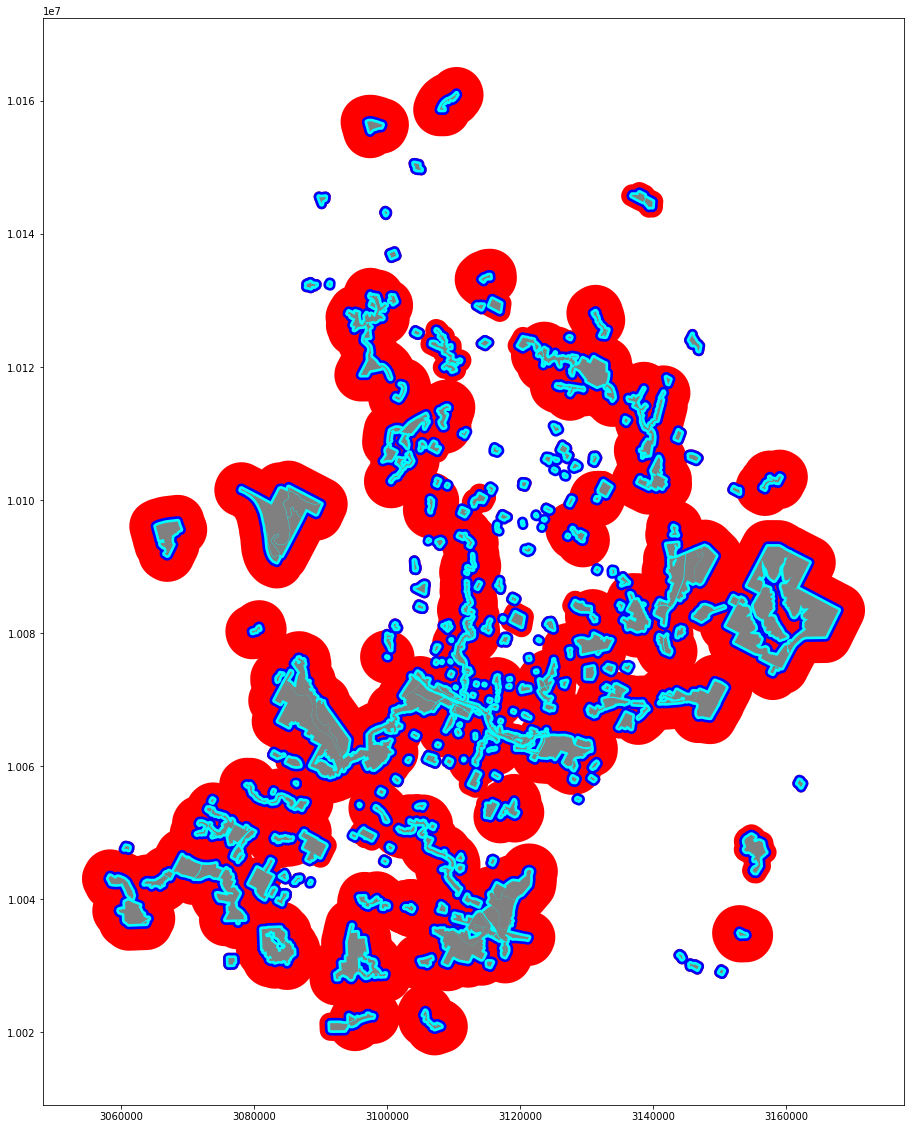

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
coaparks_vari.plot(ax = ax, color='red')
coaparks_half.plot(ax=ax, color='blue')
coaparks_quarter.plot(ax=ax, color='cyan')
coaparks.plot(ax=ax, color='grey');

## Take the difference between the park shapefile and the buffers to create a buffer shapefile that has all the attributes of the park data but does not include the park in the geometry 

In [17]:
quarterdif = coaparks.copy()
halfdif = coaparks.copy()
varidif = coaparks.copy()

#coaparks_quarter=gpd.GeoDataFrame(coaparks.buffer(400))
#coaparks_quarter=coaparks_quarter.rename(columns={0:'geometry'})

#coaparks_half=gpd.GeoDataFrame(coaparks.buffer(800))
#coaparks_half=coaparks_half.rename(columns={0:'geometry'})

In [18]:
quarterdif['geometry'] = gpd.overlay(coaparks_quarter, coaparks, how='difference')['geometry']
halfdif['geometry'] = gpd.overlay(coaparks_half, coaparks, how='difference')['geometry']
varidif['geometry'] = gpd.overlay(coaparks_vari, coaparks, how='difference')['geometry']
quarterdif = gpd.GeoDataFrame(quarterdif)

In [19]:
varidif=varidif.dropna(subset=['geometry'])
quarterdif=quarterdif.dropna(subset=['geometry'])
halfdif=halfdif.dropna(subset=['geometry'])

### Export all three buffer shapefiles. The shapefils can then be uploaded into QGIS and changed into geojson files with a WGS 84


In [20]:
quarterdif.to_file(wd+"data/coaparks_buffer/quarterbuff.shp")
halfdif.to_file(wd+"data/coaparks_buffer/halfbuff.shp")
varidif.to_file(wd+"data/coaparks_buffer/varibuff.shp")

### Unused Code

In [10]:
#plot
#fig, ax = plt.subplots(figsize=(20,20))
#vastra.plot(ax=ax)
#coaparks_half.plot(ax=ax, color='blue')
#coaparks_quarter.plot(ax=ax, color='cyan')
#coaparks.plot(ax=ax, color='grey');

#fig5, ax = plt.subplots(figsize=(12,12))
#base = coaparks.plot(ax=ax, color="black", alpha=0.2)
#layer = coaparks["geometry"].plot(ax=base, color='black', edgecolor = 'black')

#fig6, ax = plt.subplots(figsize=(12,12))
#base = quarterdif.plot(ax=ax, color="black", alpha=0.2)
#layer = quarterdif["geometry"].plot(ax=base, color='black', edgecolor = 'black')


#Export to geojson
#coaparks_half.to_file(wd+"data/coaparks_buffer/halfbuff.geojson")
#coaparks_quarter.to_file(wd+"data/coaparks_buffer/quarterbuff.geojson")
#coaparks_vari.to_file(wd+"data/coaparks_buffer/varibuff.geojson")
